In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(threshold=np.nan)
import keras
print (keras.__version__)
import tensorflow
print (tensorflow.__version__)

Using TensorFlow backend.


2.2.2
1.10.0


In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96)) # m- batch size is implicit

In [3]:
print("Total Params:", FRmodel.count_params())
#len(FRmodel.get_weights())  - takes time. uncomment to see the weights
FRmodel.summary()

Total Params: 3743280
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor-positive),axis=-1) #(shape (m,))
    neg_dist = tf.reduce_sum(tf.square(anchor-negative),axis=-1) #(shape (m,))
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))    
    return loss

In [5]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.1427


In [6]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [7]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

In [8]:
def verify(image_path, identity, database, model):
    """
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    encoding = img_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding-database[identity])
    if (dist < 0.7):
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    return dist, door_open

In [9]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome home!


(0.67100745, True)

In [10]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(0.85800153, False)

In [11]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    encoding = img_to_encoding(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(encoding-db_enc)

        if (dist<min_dist):
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [12]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.67100745


(0.67100745, 'younes')

In [13]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot_ng
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K

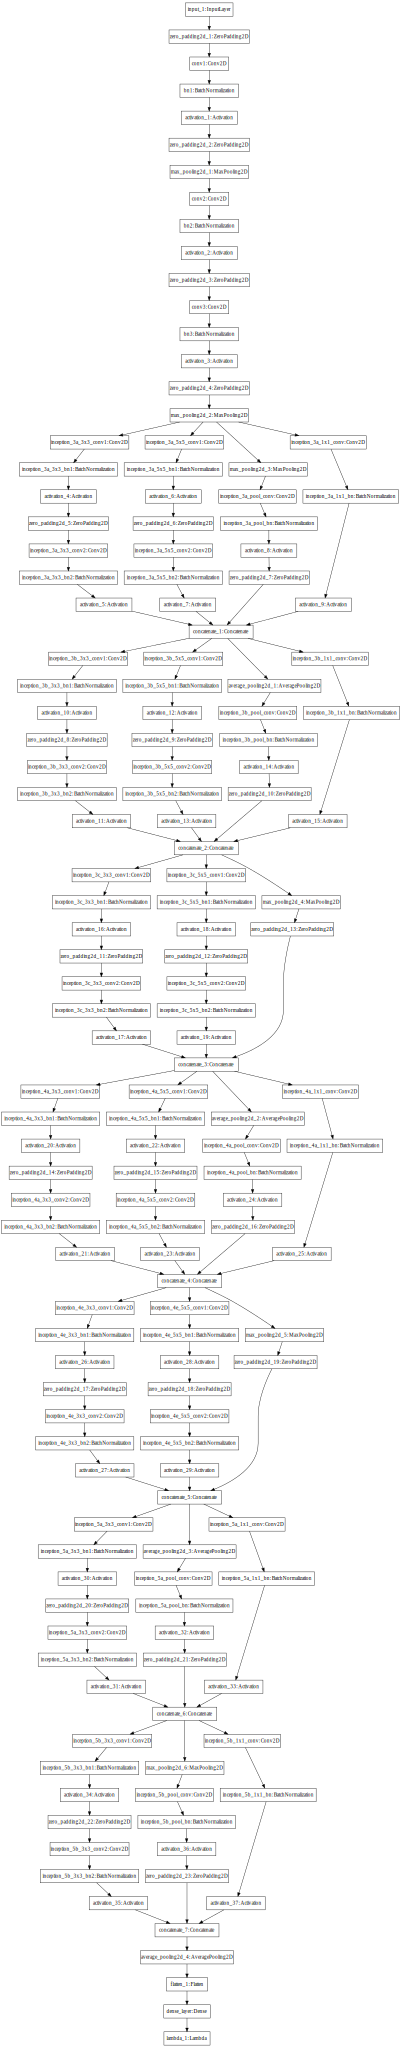

In [14]:
plot_model(FRmodel, to_file='faceRecoModel.png')
SVG(model_to_dot(FRmodel).create(prog='dot', format='svg'))